In this notebook we want to examine the effect of T1236C, T2677G and T3435C on MDR1 mRNA expression. 
We use data genomic and expression data from TCGA. 

## Imports

In [2]:
import pandas as pd
import numpy as np
import os
#from Utils_MDR1 import *
from Utils_MDR1 import variant_info, colors, get_cancer_muts_cur_gene

from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Union

## Functions

In [10]:
''' 
Get the MDR1 mRNA expression (in FPKM units) of a single TCGA patient. 
Input is patient_id, the gene_id (in our case its the MDR1 ENSEMBL ENSG id), and a dataframe that maps between the 
patient_id and its mRNA expression file on the power cluster. 
'''

def get_expression_data_single_patient(patient_id: str, gene_id: str, case_id_expression_df: pd.DataFrame) -> Union[float, str]:
    
    cur_patient_expression = case_id_expression_df[case_id_expression_df['case_id'] == patient_id] #get the rows of our patient from the expression df
    file_name = [name for name in cur_patient_expression['file_name'].to_list() if 'FPKM.' in name][0] #take only FPKM normalized expression levels
    cur_patient_expression = cur_patient_expression[cur_patient_expression['file_name'] == file_name] 
    project_id = cur_patient_expression['project_id'].values[0]
    file_UUID = cur_patient_expression['file_UUID'].values[0]

    path_expression = f"../Data/Expression/{project_id}/{file_UUID}/{file_name}"
    exp_data = pd.read_csv(path_expression, sep = "\t", header = None, names = ['gene_version','expression (FPKM)'])
    exp_data['gene'] = exp_data['gene_version'].apply(lambda x: x.split(".")[0])
    exp_gene_of_interest = exp_data[exp_data['gene'] == gene_id]['expression (FPKM)'].values[0]
    
    return(exp_gene_of_interest, project_id)


In [11]:
''' 
This function calculates the mean MDR1 expression of the mutated/carriers group (returned as "mean_expression_mutated"),
the mean MDR1 expression of all sampled non-mutated groups (returned as "mean_expressions", 
the p_value for the alternative hypothesis that exp_mutated > exp_nonmutated ("p_value_larger") and the size of the
carriers group ("num_with_mut")
'''


def get_expressions(variant_name: str, patients_with: list, expression_df: pd.DataFrame, num_randomizations: int, balanced_dict = None) -> Union[float, np.array, float, int]:

    # the control group - without the mutation/s
    exp_df_without_mut = expression_df[~expression_df['case_id'].isin(patients_with)].copy()
    num_without_mut = exp_df_without_mut.shape[0]
    
    # the case group - with the mutation/s
    if balanced_dict:
        patients_with = balanced_dict[variant_name]["with"]

    exp_df_with_mut = expression_df[expression_df['case_id'].isin(patients_with)].copy()
    num_with_mut = exp_df_with_mut.shape[0]

    #get the mean and std of the case group
    mean_expression_mutated =  exp_df_with_mut["MDR1_expression (FPKM)"].mean() #get the mean of all ptients with the mutation
    std_expression_mutated = exp_df_with_mut["MDR1_expression (FPKM)"].std() 

    #sample from the control group, "num_randomizations" groups of the same size as the control group
    mean_expressions = np.zeros((num_randomizations,1)) #initilize results vector
    for i in range(num_randomizations):
        mean_sampled_expression = exp_df_without_mut.sample(n = num_with_mut)["MDR1_expression (FPKM)"].mean() #get the mean expression of the randomly sampled patients
        mean_expressions[i,0] = mean_sampled_expression

    # Check p-value
    p_value_larger = 1 - (np.sum(mean_expression_mutated > mean_expressions) / num_randomizations)
    
    return(mean_expression_mutated, mean_expressions, p_value_larger, num_with_mut)


In [12]:
''' Violin plot for the single variants'''
def plot_violins(rand_exp1: np.array, rand_exp2: np.array, rand_exp3: np.array, mut_exp1: float, mut_exp2: float, mut_exp3: float,
                 p1: float, p2: float, p3: float ,n1: int, n2: int, n3: int, var_colors: list):

    # Create violin plots
    plt.figure(figsize=(10, 6))
    
    sns.violinplot(data=[rand_exp1, rand_exp2, rand_exp3], orient="v", inner="quartile", linewidth=1.5, palette=var_colors)
    plt.scatter([0,1,2], [mut_exp1,mut_exp2,mut_exp3], color='red', marker='o')
    
    # Adding labels and title
    plt.xticks([0, 1, 2], [f"T1236C\n(n = {n1})\np = {np.round(p1,2)}", f"T2677G\n(n = {n2})\np = {np.round(p2,2)}",
                           f"T3435C\n(n = {n3})\np = {np.round(p3,2)}"], size = 12)
    plt.xlabel('Variant', size = 15)
    plt.ylabel('Mean MDR1 expression (FPKM)', size = 15)

    # plt.savefig("../Figures/expression/violins.png", bbox_inches = "tight", dpi=500)
    # # Show the plot
    # plt.show()
    


In [13]:
''' Plot violin plot for the haplotypes '''
def plot_violins_haps(rand_exp1: np.array, rand_exp2: np.array, rand_exp3: np.array, rand_exp4: np.array, mut_exp1: float, mut_exp2: float,
                      mut_exp3: float, mut_exp4: float, p1: float, p2: float, p3: float, p4: float, n1: int, n2: int, n3: int, 
                      n4: int, var_colors: list):

    # Create violin plots
    plt.figure(figsize=(10, 6))
    
    sns.violinplot(data=[rand_exp1, rand_exp2, rand_exp3, rand_exp4], orient="v", inner="quartile", linewidth=1.5, palette=var_colors)
    plt.scatter([0,1,2,3], [mut_exp1,mut_exp2,mut_exp3, mut_exp4], color='red', marker='o')

    # Adding labels and title
    plt.xticks([0, 1, 2, 3], [f"T1236C,T2766G\n(n = {n1})\np = {np.round(p1,2)}", f"T2677G,T3435C\n(n = {n2})\np = {np.round(p2,2)}", 
                              f"T1236C,T3435C\n(n = {n3})\np = {np.round(p3,2)}", 
                              f"T1236C,T2677G,T3435C\n(n = {n4})\np = {np.round(p4,2)}"],
               size = 12)
    plt.xlabel('Variant', size = 15)
    plt.ylabel('Mean MDR1 expression (FPKM)', size = 15)

    # plt.savefig("../Figures/expression/violins_haps.png", bbox_inches = "tight", dpi=500)
    # # Show the plot
    # plt.show()
    


## Main

In [ ]:
''' Get MDR1 expression info for TCGA patients '''

gene = 'ENSG00000085563' #MDR1/ABCB1 gene
gene_name = "ABCB1"

#get a mapping between patients' case_ids and expression UUIDs, to obtain their MDR1 expression levels
case_id_mapping_df = pd.read_csv("  ../Data/Expression/expr_data_descr_gdc_manifest.2021-11-04.tsv", sep = "\t")
list_of_patients = case_id_mapping_df["case_id"].unique() #patients with expression data

#create a df that holds the MDR1 expression levels of all TCGA patients that have measuremets.
patients = []
mdr1_expression_values = []
cancer_types = []

expression_df = pd.DataFrame()

for patient in tqdm(list_of_patients):
    try:
        mdr1_exp, cancer_type = get_expression_data_single_patient(patient, gene, case_id_mapping_df)
        patients.append(patient)
        mdr1_expression_values.append(mdr1_exp)
        cancer_types.append(cancer_type)
    except:
        pass
    
expression_df["case_id"] = patients
expression_df["project"] = cancer_types
expression_df["MDR1_expression (FPKM)"] = mdr1_expression_values

with open(f"../Data/MDR1_expression_df.pickle",'wb') as f:
    pickle.dump(expression_df, f)
    

## Single Variants - Figure 1

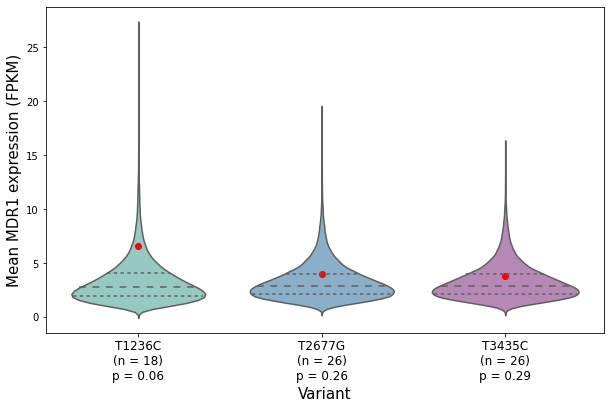

In [28]:
# get info of the gene
gene = 'ENSG00000085563' #MDR1/ABCB1 gene
gene_name = "ABCB1"
expression_df = pd.read_pickle(f"../Data/MDR1_expression_df.pickle") #a df with the expression of MDR1 for all TCGA patients
patients_dict = pd.read_pickle(f"../Data/mutated_patients_dict.pickle") #lists carriers' patient_ids for each variant

num_randomizations = 100000
# basic data on the three variants is imported from Utils_MDR1.ipynb as the parameter "variant_info"
''' get expression data for the mutated and sampled non-mutated groups for T1236C'''
num_mut = 1 #T1236C
variant_name = variant_info[num_mut]["variant_name"]
patients_with_mut = patients_dict[variant_name] #patient_ids for the carriers
mut_exp1, rand_exp1, p1, n1 = get_expressions(variant_name, patients_with_mut, expression_df, num_randomizations) #p1 is the p-value,
#n1 is the number of patients in the carriers group (same as the sampled non-carriers group)

''' get expression data for the mutated and sampled non-mutated groups for T2677G '''
num_mut = 2 
variant_name = variant_info[num_mut]["variant_name"]
patients_with_mut = patients_dict[variant_name]
mut_exp2, rand_exp2, p2, n2 = get_expressions(variant_name, patients_with_mut, expression_df, num_randomizations)

''' get expression data for the mutated and sampled non-mutated groups for T3435C '''
num_mut = 3
variant_name = variant_info[num_mut]["variant_name"]
patients_with_mut = patients_dict[variant_name]
mut_exp3, rand_exp3, p3, n3 = get_expressions(variant_name, patients_with_mut, expression_df, num_randomizations)

''' plot '''
var_colors = [colors[0], colors[4], colors[9]]
plot_violins(rand_exp1, rand_exp2, rand_exp3, mut_exp1, mut_exp2, mut_exp3, p1, p2, p3, n1, n2, n3, var_colors)


## Haplotypes - Figure S2

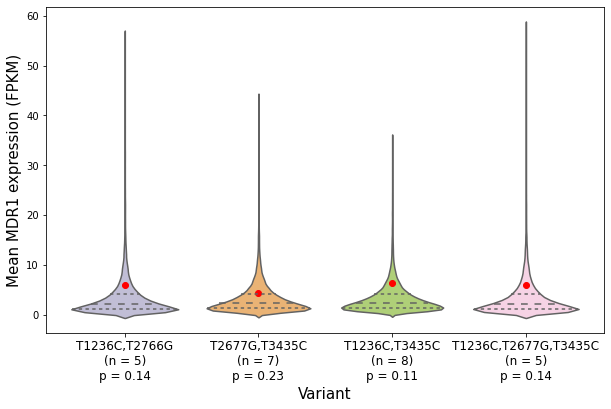

In [29]:
num_randomizations = 100000

# get info for all haplotypes
gene = 'ENSG00000085563' #MDR1/ABCB1 gene
gene_name = "ABCB1"
expression_df = pd.read_pickle(f"../Data/MDR1_expression_df.pickle")
patients_dict = pd.read_pickle(f"../Data/mutated_patients_dict.pickle")

# hap 1
variant_name = "T1236C_T2677G"
patients_with_mut = patients_dict[variant_name]
mut_exp12, rand_exp12, p12, n12 = get_expressions(variant_name, patients_with_mut, expression_df, num_randomizations)

# hap 2
variant_name = "T1236C_T3435C"
patients_with_mut = patients_dict[variant_name]
mut_exp13, rand_exp13, p13, n13 = get_expressions(variant_name, patients_with_mut, expression_df, num_randomizations)

# hap 3
variant_name = "T2677G_T3435C"
patients_with_mut = patients_dict[variant_name]
mut_exp23, rand_exp23, p23, n23 = get_expressions(variant_name, patients_with_mut, expression_df, num_randomizations)

# hap 4
variant_name = "T1236C_T2677G_T3435C"
patients_with_mut = patients_dict[variant_name]
mut_exp123, rand_exp123, p123, n123 = get_expressions(variant_name, patients_with_mut, expression_df, num_randomizations)

#plot
var_colors = colors[2], colors[5], colors[6], colors[7]
plot_violins_haps(rand_exp12, rand_exp13, rand_exp23, rand_exp123, mut_exp12, mut_exp13, mut_exp23, mut_exp123, p12, p13, p23, p123, n12,
                  n13, n23, n123, var_colors)
